In [1]:
from random import sample

# 常规导包
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, firwin2, fftconvolve,stft
from sympy import symbols,exp,I

In [2]:
def generate_target_psd_noise(filter_order,samples,psd,noise,freq_vec):
    b = firwin2(filter_order + 1,freq_vec/(samples/2) ,np.sqrt(psd))
    output_noise = np.sqrt(samples)* fftconvolve(b,noise)
    return output_noise
    

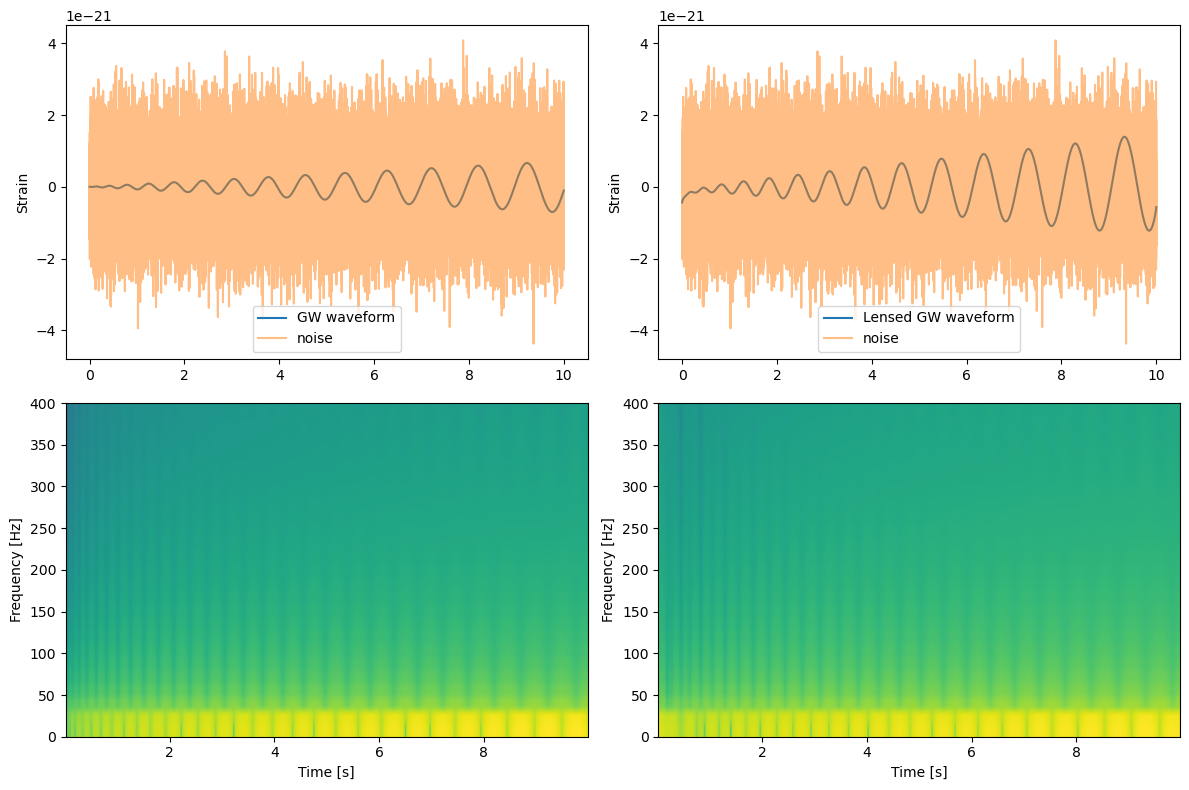

In [27]:
# 定义参数
# 质量的影响的是形状
m1 = m2 = 15 # 双星质量，单位 kg
M = m1 + m2  # 总质量，单位 kg
miu = (m1 + m2) / M 
# 距离越小，振幅越大嘿！
D_L = 1000 *1e6
D_LS = 100 * 1e6 # 将这两个的单位都转换为pc
D_S = D_L + D_LS # 距离，单位 m (1 Mpc = 3.086 * 10^22 m)
# 论文中规定用单位量
c = 1  # 光速，单位 m/s
G = 1  # 引力常数，单位 m^3 kg^(-1) s^(-2)


t = np.linspace(0, 10, 40960)  # 时间数组，单位 s    -10~0的没有做，因为确实不能计算
dataLen = t.shape[0]
fs = dataLen / (t[-1] - t[0])
f = np.linspace(10,1000,dataLen) # 影响的好像是振幅


# 计算后牛顿参数和轨道相位
eta = miu / M
theta_t = eta * t / 5 * M # 待定
x_t = theta_t * (-1 / 4) / 4
phi_t = -1 * theta_t ** (5 / 8) / eta

# 计算引力波波形
h_t = -8 * np.sqrt(np.pi / 5) * miu / D_S * np.exp(-2j * phi_t) * x_t #应该是复数吧，一定是的吧
h_t = h_t * 1e-12


# 模拟透镜效应
yipuxilong = 0.25
M_l = 1e3  # 透镜的质量
yipuxilong_0 = np.sqrt((4 * G * M_l / c ** 2) * (D_LS / D_L * D_S ))
y = yipuxilong * D_L / (yipuxilong_0 * D_S)
beita = np.sqrt(y ** 2 + 4)
z = 1
M_lz = M_l * (1 + z)
deita_td = 4 * M_lz * ((y * beita / 2) + np.log((beita + y) / (beita - y)))
u_add = 1/2 + ((y **2 + 2) / (2 * y * beita))
u_sub = 1/2 - ((y **2 + 2) / (2 * y * beita))

# 点质量透镜模型公式
F_f = np.abs(u_add) ** (1/2) - 1j*np.abs(u_sub) ** (1/2) * np.exp(2j * np.pi * f * deita_td) 
h_f = np.fft.fft(h_t) # 将上面的波形从时域转换到频域
h_lens_f = F_f * h_f # 将这个波形透镜化
h_lens_t = np.fft.ifft(h_lens_f)   # 转换为时域
h_lens_t = h_lens_t * 1e-3


# 生成高斯噪声r
noise = np.random.normal(0, 1, h_t.shape[0])
noise = noise * 1e-21

# 绘制引力波波形和噪声
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# 后牛顿波形
axs[0, 0].plot(t, np.real(h_t), label='GW waveform')
axs[0, 0].plot(t, noise, label='noise', alpha=0.5)
axs[0, 0].set_ylabel('Strain')
axs[0, 0].legend()

# 透镜效应后的波形
axs[0, 1].plot(t, np.real(h_lens_t), label='Lensed GW waveform')
axs[0, 1].plot(t, noise, label='noise', alpha=0.5)
axs[0, 1].set_ylabel('Strain')
axs[0, 1].legend()

# 后牛顿波形的频谱图
Z, freqs, times, im = axs[1, 0].specgram(h_t.real, Fs=fs)
axs[1, 0].set_xlabel('Time [s]')
axs[1, 0].set_ylabel('Frequency [Hz]')
axs[1, 0].set_ylim(0,400)

# 透镜效应后波形的频谱图
Z_lensed, _, _, _ = axs[1, 1].specgram(h_lens_t.real, Fs=fs)
axs[1, 1].set_xlabel('Time [s]')
axs[1, 1].set_ylabel('Frequency [Hz]')
axs[1, 1].set_ylim(0,400)

plt.tight_layout()
plt.show()

In [ ]:
# 生成噪声

# 获取频率和噪声功率谱密度
freq_psd = np.loadtxt('aligo_design.txt')

posfreqs = freq_psd[:,0]
psd = freq_psd[:,1]

fig = plt.figure()
plt.plot(posfreqs, psd, 'b')
plt.yscale('log')

plt.show()


In [ ]:
# 生成噪声
initial_noise = np.random.normal(0,1,nsamples)
filter_order = 200
output_noise = generate_target_psd_noise(filter_order,samples,psd,initial_noise,posfreqs)



f,pxx = welch(output_noise,fs = samples)

fig = plt.figure(figsize = (12,8))
plt.subplot(3,1,1)
plt.plot(f,pxx,'b')
plt.yscale('log')
plt.xlim(0,500)

plt.subplot(3,1,2)
plt.plot(timeVec,output_noise[:len(timeVec)],'b')


plt.subplot(3,1,3)
plt.plot(timeVec,initial_noise,'b')
plt.show()

